In [1]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [2]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i], t2s[met_i - 1:met_i], M_0s[met_i - 1:met_i]
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [3]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

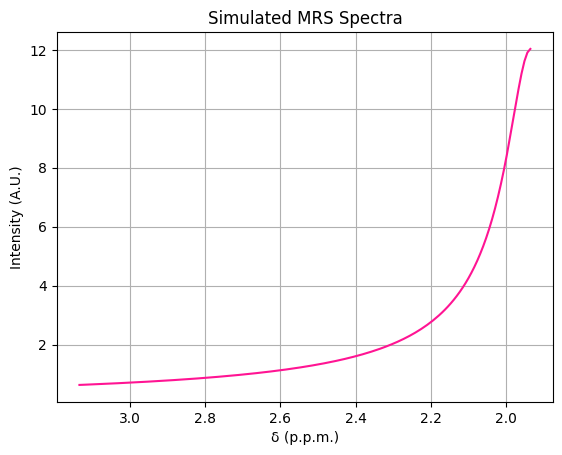

In [4]:
# pymri.plot_chem_shifts(freqs, sig_fft, 1.0)
Delta = 1.2

select_arr = freqs <= pymri.chem_shift_from_f(pymri.rad_to_hz(ws[0]), B0) + Delta
select_arr = np.bitwise_and(select_arr, freqs > pymri.chem_shift_from_f(pymri.rad_to_hz(ws[0]), B0) - Delta)

pymri.plot_chem_shifts(freqs[select_arr], sig_fft[select_arr], 1.0)

In [5]:
snrs = np.array([1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 25.0, 37.50, 50.0, 62.50, 75.0, 87.50, 100.0])

In [6]:
L = 0.4
noise_threshold = 1e-30
L_ = int(L*sig.size)

In [7]:
print(pymri.chem_shift_from_f(pymri.rad_to_hz(ws), B0))

[1.9346]


In [8]:
c_sigs = np.zeros((snrs.size, sig.size), dtype = np.complex128)
r_sigs = np.zeros((snrs.size, sig.size), dtype = np.complex128)
residues = np.zeros((snrs.size, sig.size), dtype = np.complex128)
s0__ = np.array([{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}])
phi__ = np.array([{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}])
omega__ = np.array([{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}])
t2s__ = np.array([{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}])

for i in range(snrs.size):

    c_sig_fft = awgn(sig_fft, snrs[i])
    c_sigs[i, :]  = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

    fil_sig, z, r = pymri.filter_sig(c_sigs[i, :], L, noise_threshold, return_full_arrays=True, return_poles_and_res=True)
    s0s, phis, omegas, t2s = pymri.calculate_variables_from_z_and_r(z, r, dt)
    t2s = 1/t2s
    s0__[i][0], phi__[i][0], omega__[i][0], t2s__[i][0], n_comp = pymri.select_peaks(s0s, phis, omegas, t2s)
    r_sigs[i, :], t_ = pymri.population_transverse_decay(t0, tn, dt, pymri.population(omega__[i][0], t2s__[i][0], s0__[i][0], phi__[i][0]))
    freqs, r_sigs[i, :] = pymri.fourier_spectrum(r_sigs[i, :], dt, B0)
    freqs, c_sigs[i, :] = pymri.fourier_spectrum(c_sigs[i, :], dt, B0)
    residues[i, :] = c_sigs[i, :] - r_sigs[i, :]

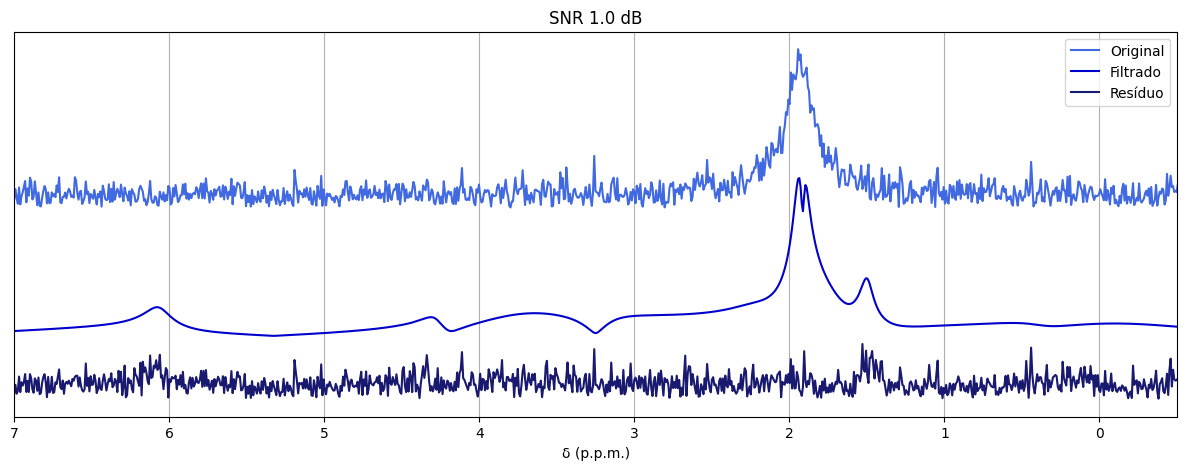

In [31]:
yoffset = 5.0
i = 0

plt.figure(figsize=(15, 5))

plt.plot(freqs, np.absolute(c_sigs[i, :]) + 3*yoffset, c = "royalblue", label = "Original")
plt.plot(freqs, np.absolute(r_sigs[i, :]) + yoffset, c = "mediumblue", label = "Filtrado")
plt.plot(freqs,  np.absolute(residues[i, :]), c = "midnightblue", label = "Resíduo")
plt.xlim(-0.5, 7.0)
plt.title(f"SNR {snrs[i]} dB")
plt.xlabel("δ (p.p.m.)")
# plt.ylabel("Intensidade (U.A.)")
plt.xlim(-0.5, 7.0)
plt.yticks([])
plt.legend()
plt.gca().invert_xaxis() #inverts the x axis
plt.grid()

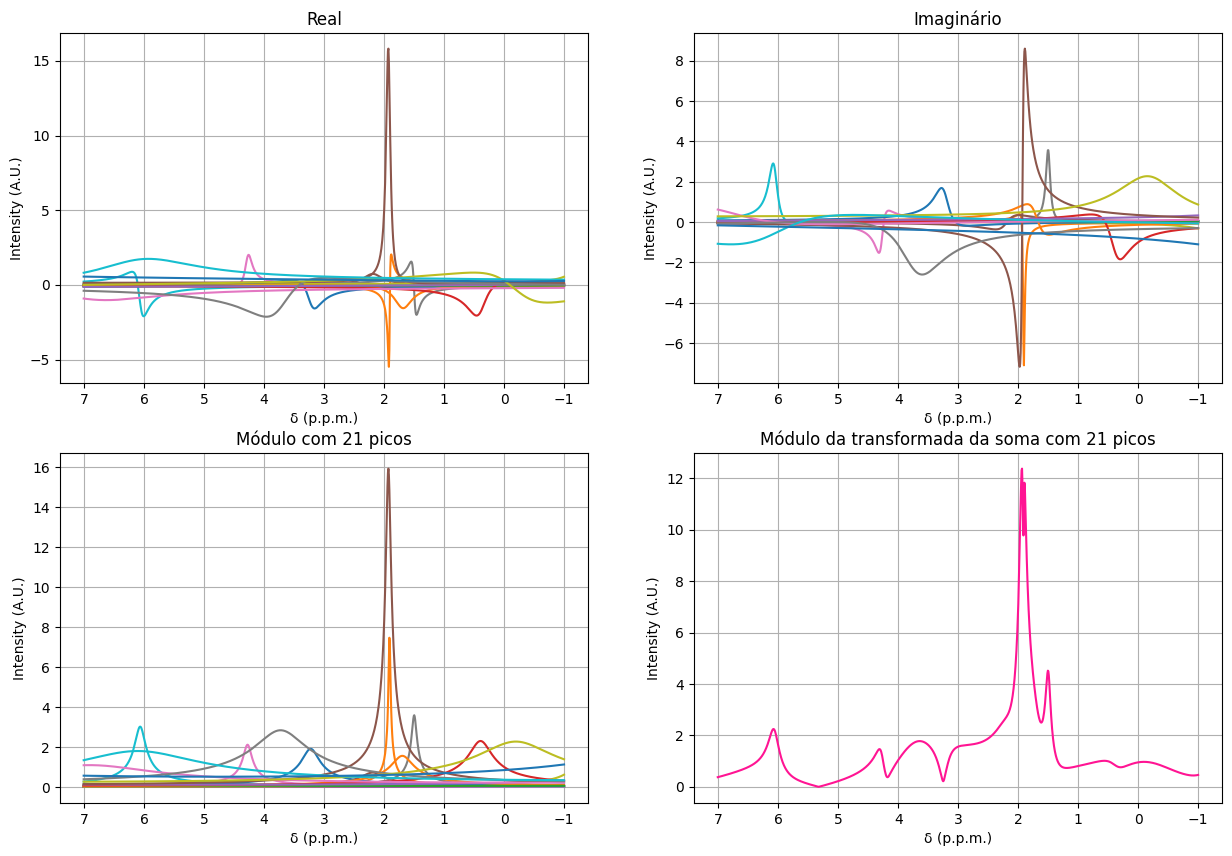

In [32]:
_n_comp = s0__[i][0].size
individual_sigs = np.zeros((_n_comp, c_sigs[0].size), dtype = np.complex128)

for j in range(_n_comp):
    pop = pymri.population(np.array([omega__[i][0][j]]), np.array([t2s__[i][0][j]]), np.array([s0__[i][0][j]]), np.array([phi__[i][0][j]]))
    individual_sigs[j] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]

final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

plt.figure(figsize=(15, 10))
plt.subplot(221)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="real", title= "Real", label=f"{_n_comp - j} maior")

plt.subplot(222)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="imag", title="Imaginário", label=f"{_n_comp - j} maior")

plt.subplot(223)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="abs", title=f"Módulo com {_n_comp} picos", label=f"{_n_comp - j} maior")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = f"Módulo da transformada da soma com {_n_comp} picos", label = "")

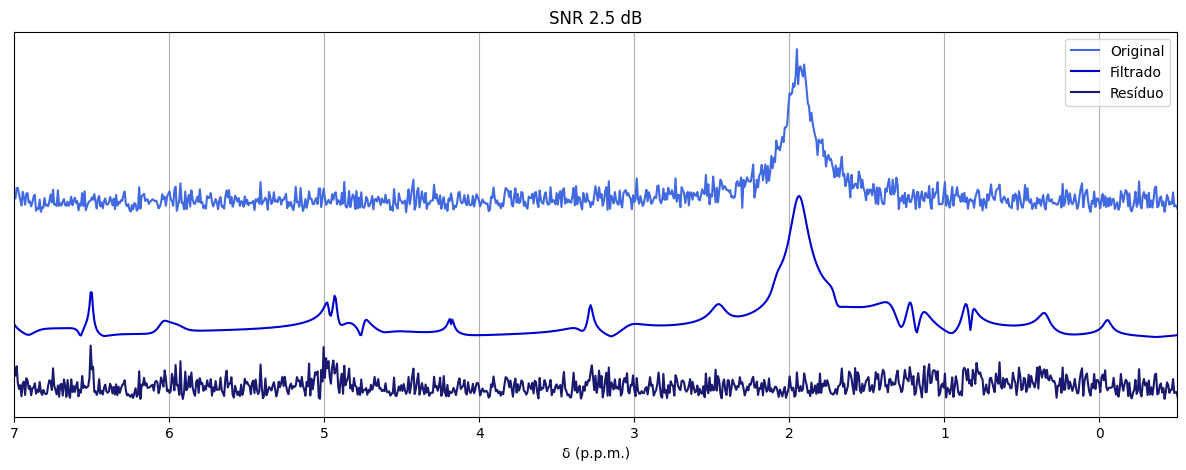

In [33]:
yoffset = 5.0
i = 1

plt.figure(figsize=(15, 5))

plt.plot(freqs, np.absolute(c_sigs[i, :]) + 3*yoffset, c = "royalblue", label = "Original")
plt.plot(freqs, np.absolute(r_sigs[i, :]) + yoffset, c = "mediumblue", label = "Filtrado")
plt.plot(freqs,  np.absolute(residues[i, :]), c = "midnightblue", label = "Resíduo")
plt.title(f"SNR {snrs[i]} dB")
plt.xlabel("δ (p.p.m.)")
# plt.ylabel("Intensidade (U.A.)")
plt.xlim(-0.5, 7.0)
plt.yticks([])
plt.legend()
plt.gca().invert_xaxis() #inverts the x axis
plt.grid()

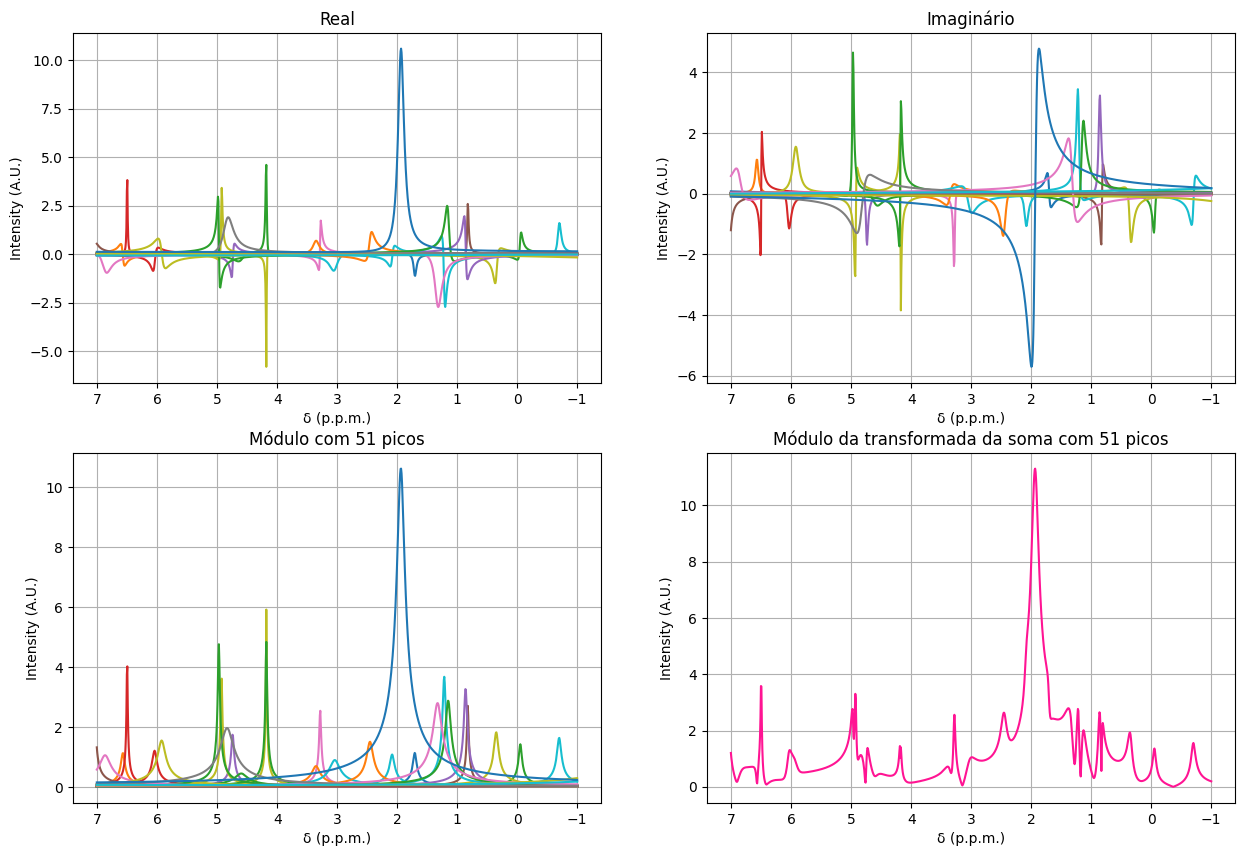

In [34]:
_n_comp = s0__[i][0].size
individual_sigs = np.zeros((_n_comp, c_sigs[0].size), dtype = np.complex128)

for j in range(_n_comp):
    pop = pymri.population(np.array([omega__[i][0][j]]), np.array([t2s__[i][0][j]]), np.array([s0__[i][0][j]]), np.array([phi__[i][0][j]]))
    individual_sigs[j] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]

final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

plt.figure(figsize=(15, 10))
plt.subplot(221)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="real", title= "Real", label=f"{_n_comp - j} maior")

plt.subplot(222)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="imag", title="Imaginário", label=f"{_n_comp - j} maior")

plt.subplot(223)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="abs", title=f"Módulo com {_n_comp} picos", label=f"{_n_comp - j} maior")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = f"Módulo da transformada da soma com {_n_comp} picos", label = "")

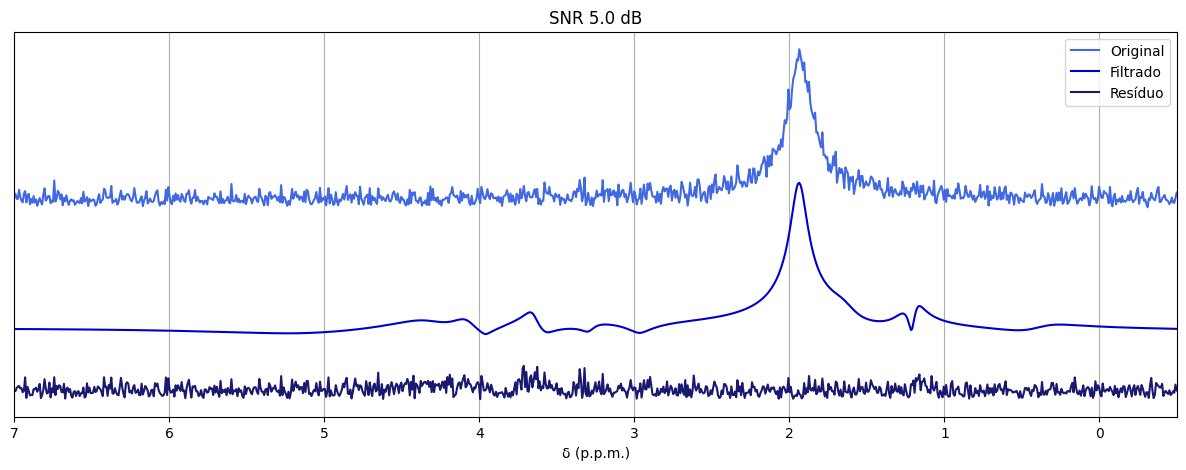

In [35]:
yoffset = 5.0
i = 2

plt.figure(figsize=(15, 5))

plt.plot(freqs, np.absolute(c_sigs[i, :]) + 3*yoffset, c = "royalblue", label = "Original")
plt.plot(freqs, np.absolute(r_sigs[i, :]) + yoffset, c = "mediumblue", label = "Filtrado")
plt.plot(freqs,  np.absolute(residues[i, :]), c = "midnightblue", label = "Resíduo")
plt.title(f"SNR {snrs[i]} dB")
plt.xlabel("δ (p.p.m.)")
# plt.ylabel("Intensidade (U.A.)")
plt.xlim(-0.5, 7.0)
plt.yticks([])
plt.legend()
plt.gca().invert_xaxis() #inverts the x axis
plt.grid()

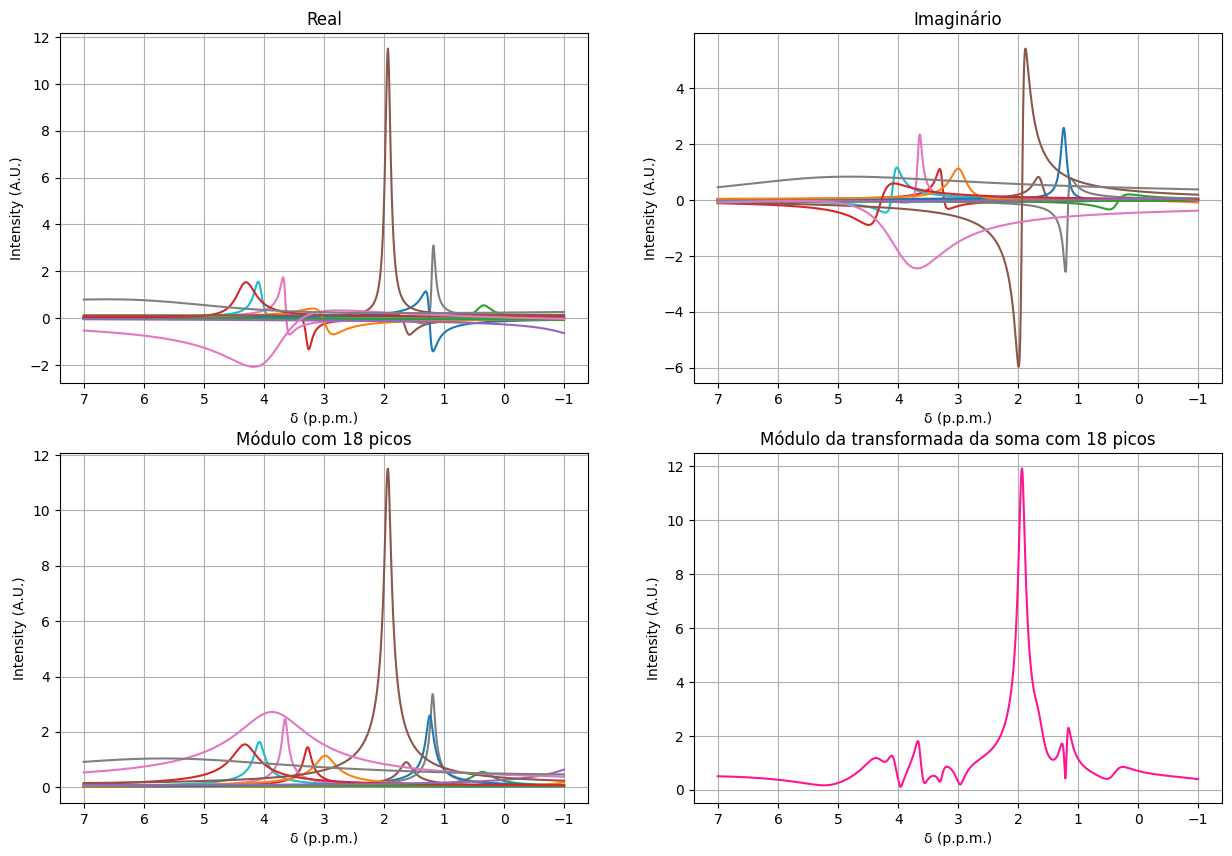

In [36]:
_n_comp = s0__[i][0].size
individual_sigs = np.zeros((_n_comp, c_sigs[0].size), dtype = np.complex128)

for j in range(_n_comp):
    pop = pymri.population(np.array([omega__[i][0][j]]), np.array([t2s__[i][0][j]]), np.array([s0__[i][0][j]]), np.array([phi__[i][0][j]]))
    individual_sigs[j] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]

final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

plt.figure(figsize=(15, 10))
plt.subplot(221)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="real", title= "Real", label=f"{_n_comp - j} maior")

plt.subplot(222)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="imag", title="Imaginário", label=f"{_n_comp - j} maior")

plt.subplot(223)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="abs", title=f"Módulo com {_n_comp} picos", label=f"{_n_comp - j} maior")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = f"Módulo da transformada da soma com {_n_comp} picos", label = "")

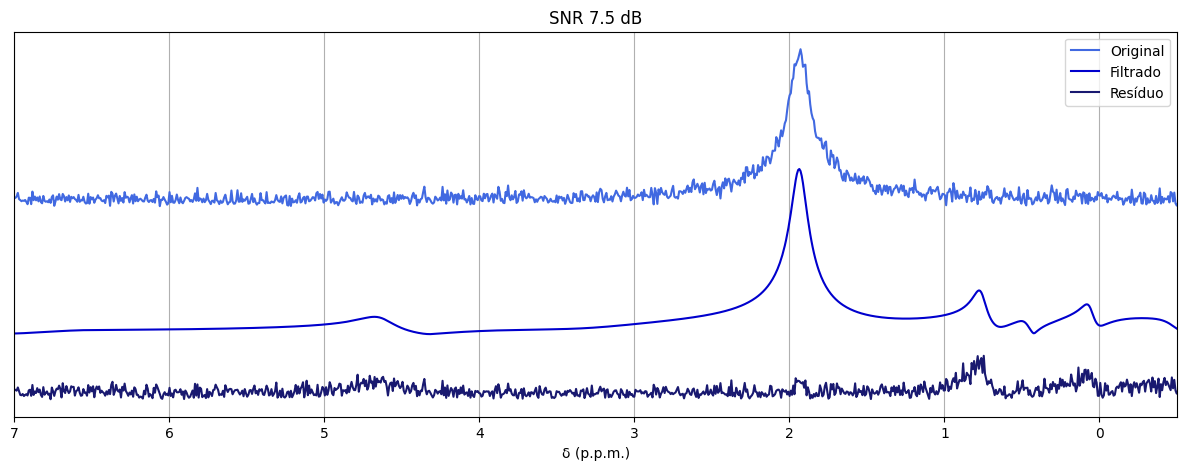

In [37]:
yoffset = 5.0
i = 3

plt.figure(figsize=(15, 5))

plt.plot(freqs, np.absolute(c_sigs[i, :]) + 3*yoffset, c = "royalblue", label = "Original")
plt.plot(freqs, np.absolute(r_sigs[i, :]) + yoffset, c = "mediumblue", label = "Filtrado")
plt.plot(freqs,  np.absolute(residues[i, :]), c = "midnightblue", label = "Resíduo")
plt.xlim(-0.5, 7.0)
plt.title(f"SNR {snrs[i]} dB")
plt.xlabel("δ (p.p.m.)")
# plt.ylabel("Intensidade (U.A.)")
plt.yticks([])
plt.legend()
plt.gca().invert_xaxis() #inverts the x axis
plt.grid()

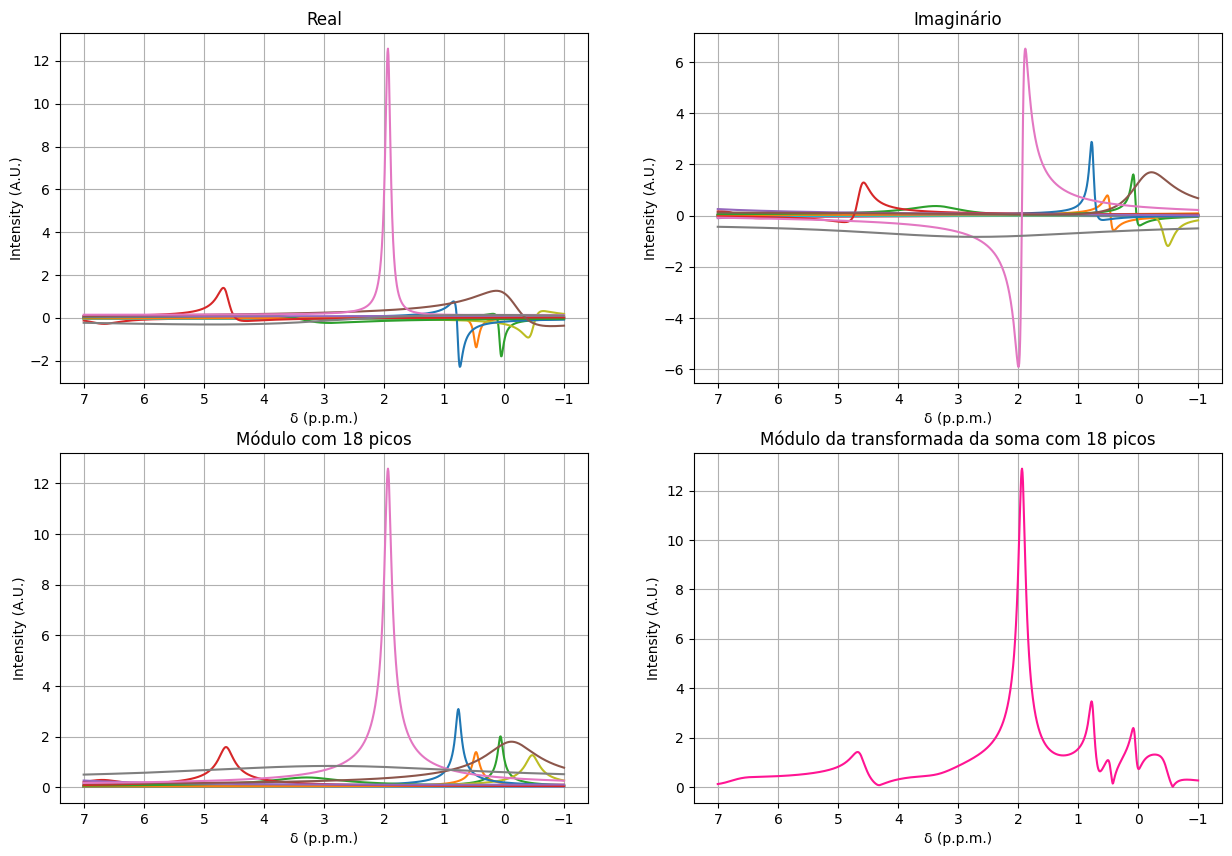

In [38]:
_n_comp = s0__[i][0].size
individual_sigs = np.zeros((_n_comp, c_sigs[0].size), dtype = np.complex128)

for j in range(_n_comp):
    pop = pymri.population(np.array([omega__[i][0][j]]), np.array([t2s__[i][0][j]]), np.array([s0__[i][0][j]]), np.array([phi__[i][0][j]]))
    individual_sigs[j] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]

final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

plt.figure(figsize=(15, 10))
plt.subplot(221)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="real", title= "Real", label=f"{_n_comp - j} maior")

plt.subplot(222)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="imag", title="Imaginário", label=f"{_n_comp - j} maior")

plt.subplot(223)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="abs", title=f"Módulo com {_n_comp} picos", label=f"{_n_comp - j} maior")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = f"Módulo da transformada da soma com {_n_comp} picos", label = "")

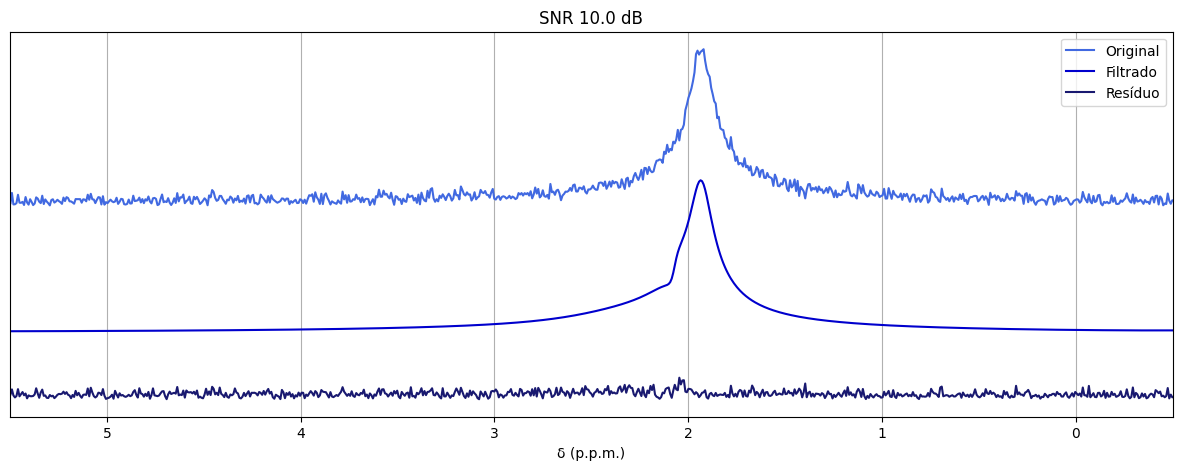

In [39]:
yoffset = 5.0
i = 4

plt.figure(figsize=(15, 5))

plt.plot(freqs, np.absolute(c_sigs[i, :]) + 3*yoffset, c = "royalblue", label = "Original")
plt.plot(freqs, np.absolute(r_sigs[i, :]) + yoffset, c = "mediumblue", label = "Filtrado")
plt.plot(freqs,  np.absolute(residues[i, :]), c = "midnightblue", label = "Resíduo")
plt.xlim(-0.5, 5.5)
plt.title(f"SNR {snrs[i]} dB")
plt.xlabel("δ (p.p.m.)")
# plt.ylabel("Intensidade (U.A.)")
plt.xlim(-0.5, 5.5)
plt.yticks([])
plt.legend()
plt.gca().invert_xaxis() #inverts the x axis
plt.grid()

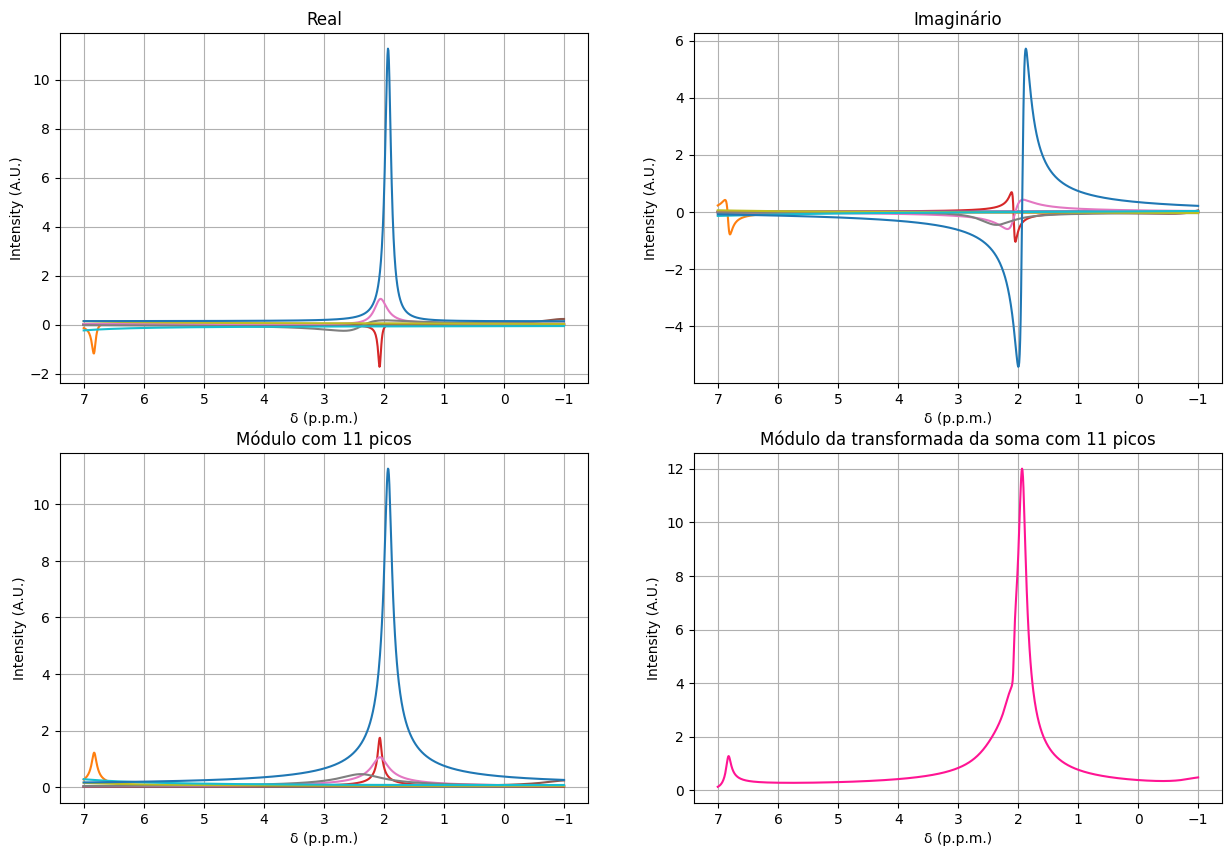

In [40]:
_n_comp = s0__[i][0].size
individual_sigs = np.zeros((_n_comp, c_sigs[0].size), dtype = np.complex128)

for j in range(_n_comp):
    pop = pymri.population(np.array([omega__[i][0][j]]), np.array([t2s__[i][0][j]]), np.array([s0__[i][0][j]]), np.array([phi__[i][0][j]]))
    individual_sigs[j] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]

final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

plt.figure(figsize=(15, 10))
plt.subplot(221)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="real", title= "Real", label=f"{_n_comp - j} maior")

plt.subplot(222)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="imag", title="Imaginário", label=f"{_n_comp - j} maior")

plt.subplot(223)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="abs", title=f"Módulo com {_n_comp} picos", label=f"{_n_comp - j} maior")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = f"Módulo da transformada da soma com {_n_comp} picos", label = "")

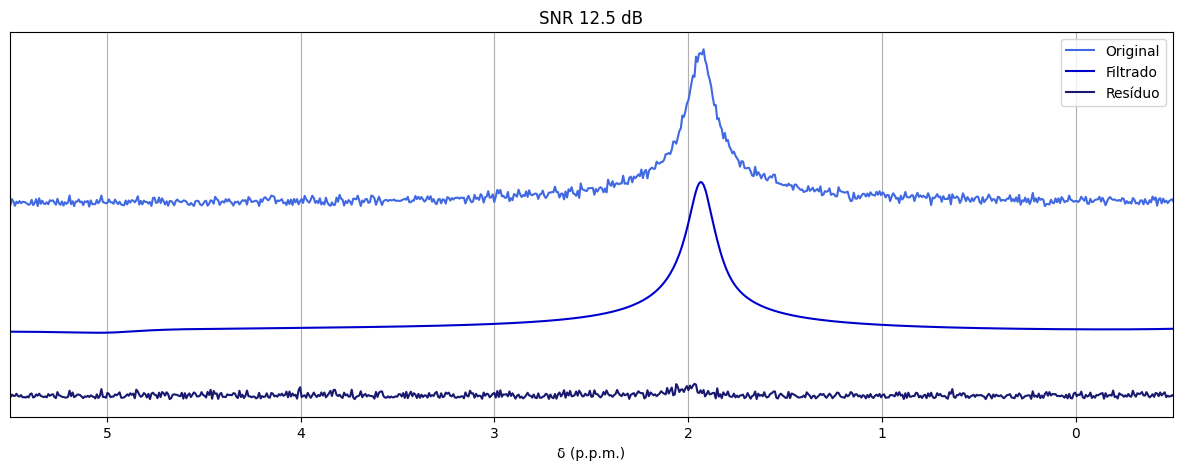

In [41]:
yoffset = 5.0
i = 5

plt.figure(figsize=(15, 5))

plt.plot(freqs, np.absolute(c_sigs[i, :]) + 3*yoffset, c = "royalblue", label = "Original")
plt.plot(freqs, np.absolute(r_sigs[i, :]) + yoffset, c = "mediumblue", label = "Filtrado")
plt.plot(freqs,  np.absolute(residues[i, :]), c = "midnightblue", label = "Resíduo")
plt.xlim(-0.5, 5.5)
plt.title(f"SNR {snrs[i]} dB")
plt.xlabel("δ (p.p.m.)")
# plt.ylabel("Intensidade (U.A.)")
plt.xlim(-0.5, 5.5)
plt.yticks([])
plt.legend()
plt.gca().invert_xaxis() #inverts the x axis
plt.grid()

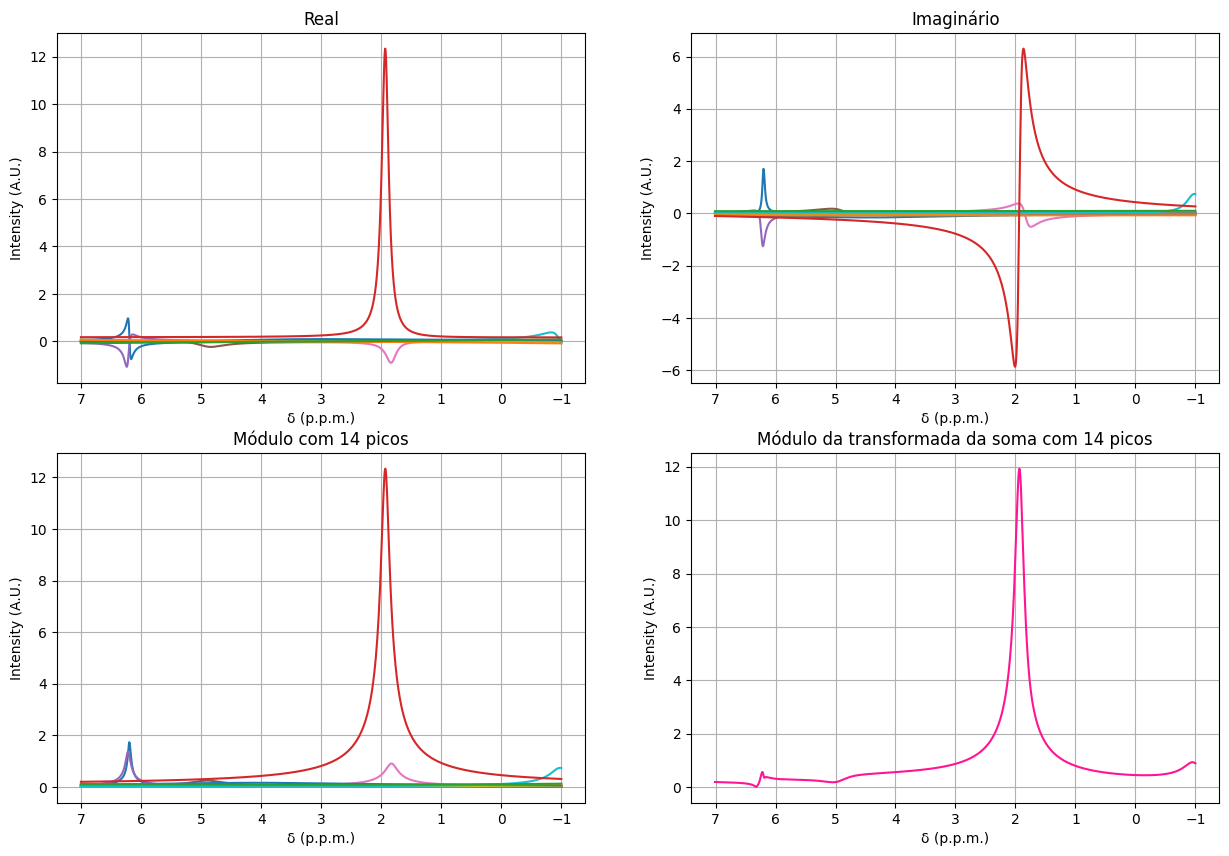

In [42]:
_n_comp = s0__[i][0].size
individual_sigs = np.zeros((_n_comp, c_sigs[0].size), dtype = np.complex128)

for j in range(_n_comp):
    pop = pymri.population(np.array([omega__[i][0][j]]), np.array([t2s__[i][0][j]]), np.array([s0__[i][0][j]]), np.array([phi__[i][0][j]]))
    individual_sigs[j] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]

final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

plt.figure(figsize=(15, 10))
plt.subplot(221)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="real", title= "Real", label=f"{_n_comp - j} maior")

plt.subplot(222)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="imag", title="Imaginário", label=f"{_n_comp - j} maior")

plt.subplot(223)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="abs", title=f"Módulo com {_n_comp} picos", label=f"{_n_comp - j} maior")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = f"Módulo da transformada da soma com {_n_comp} picos", label = "")

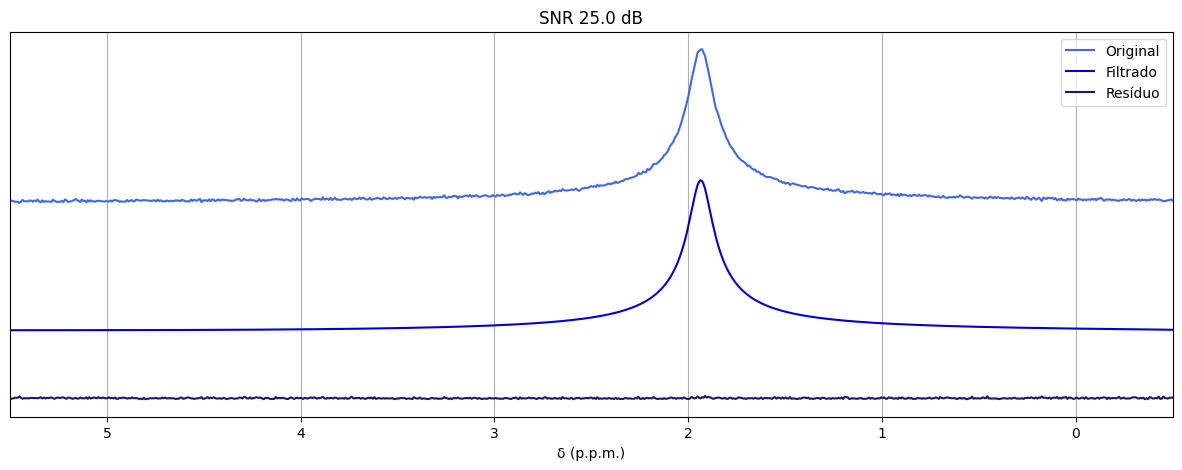

In [43]:
yoffset = 5.0
i = 6

plt.figure(figsize=(15, 5))

plt.plot(freqs, np.absolute(c_sigs[i, :]) + 3*yoffset, c = "royalblue", label = "Original")
plt.plot(freqs, np.absolute(r_sigs[i, :]) + yoffset, c = "mediumblue", label = "Filtrado")
plt.plot(freqs,  np.absolute(residues[i, :]), c = "midnightblue", label = "Resíduo")
plt.xlim(-0.5, 5.5)
plt.title(f"SNR {snrs[i]} dB")
plt.xlabel("δ (p.p.m.)")
# plt.ylabel("Intensidade (U.A.)")
plt.xlim(-0.5, 5.5)
plt.yticks([])
plt.legend()
plt.gca().invert_xaxis() #inverts the x axis
plt.grid()

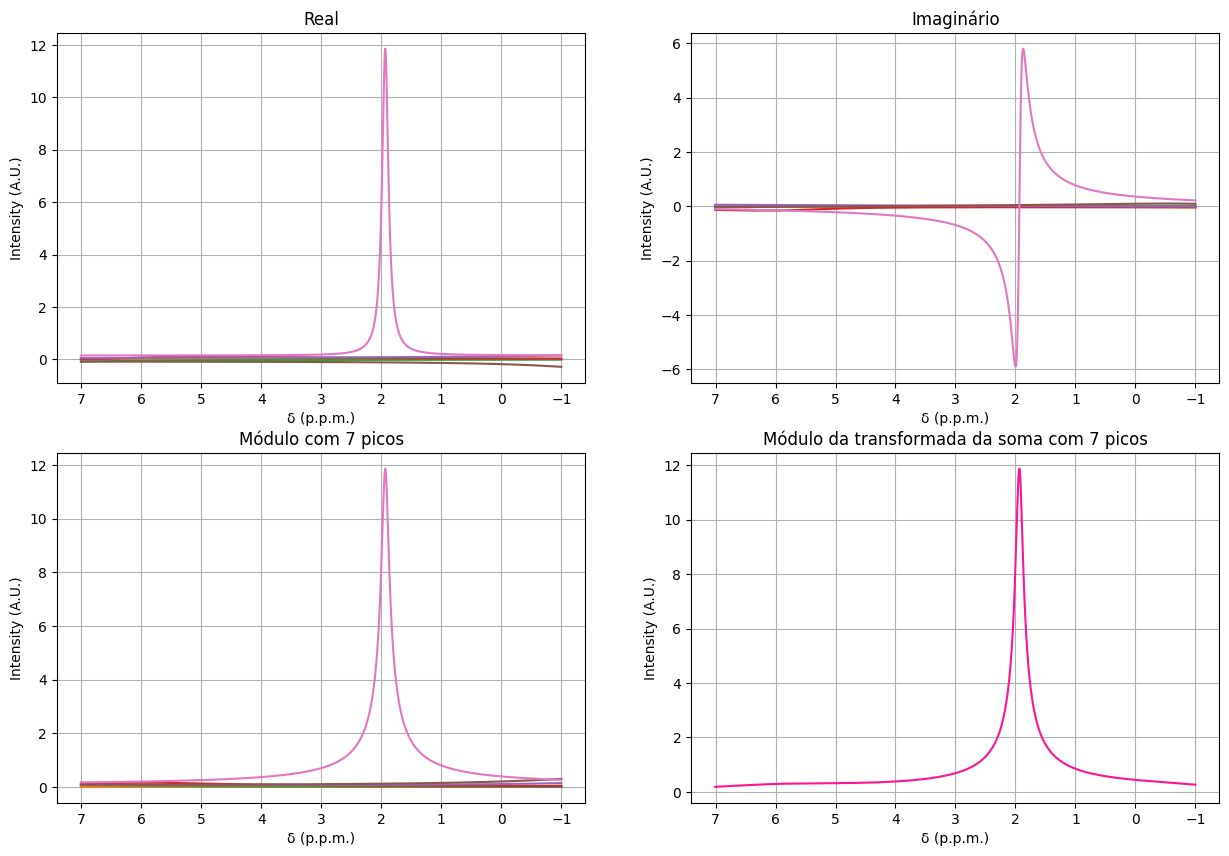

In [44]:
_n_comp = s0__[i][0].size
individual_sigs = np.zeros((_n_comp, c_sigs[0].size), dtype = np.complex128)

for j in range(_n_comp):
    pop = pymri.population(np.array([omega__[i][0][j]]), np.array([t2s__[i][0][j]]), np.array([s0__[i][0][j]]), np.array([phi__[i][0][j]]))
    individual_sigs[j] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]

final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

plt.figure(figsize=(15, 10))
plt.subplot(221)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="real", title= "Real", label=f"{_n_comp - j} maior")

plt.subplot(222)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="imag", title="Imaginário", label=f"{_n_comp - j} maior")

plt.subplot(223)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="abs", title=f"Módulo com {_n_comp} picos", label=f"{_n_comp - j} maior")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = f"Módulo da transformada da soma com {_n_comp} picos", label = "")

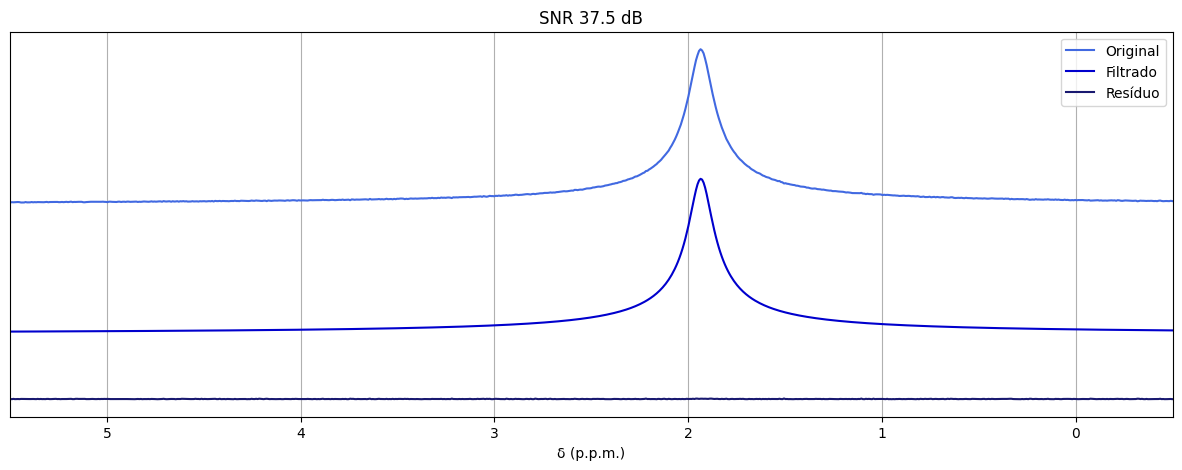

In [45]:
yoffset = 5.0
i = 7

plt.figure(figsize=(15, 5))

plt.plot(freqs, np.absolute(c_sigs[i, :]) + 3*yoffset, c = "royalblue", label = "Original")
plt.plot(freqs, np.absolute(r_sigs[i, :]) + yoffset, c = "mediumblue", label = "Filtrado")
plt.plot(freqs,  np.absolute(residues[i, :]), c = "midnightblue", label = "Resíduo")
plt.xlim(-0.5, 5.5)
plt.title(f"SNR {snrs[i]} dB")
plt.xlabel("δ (p.p.m.)")
# plt.ylabel("Intensidade (U.A.)")
plt.xlim(-0.5, 5.5)
plt.yticks([])
plt.legend()
plt.gca().invert_xaxis() #inverts the x axis
plt.grid()

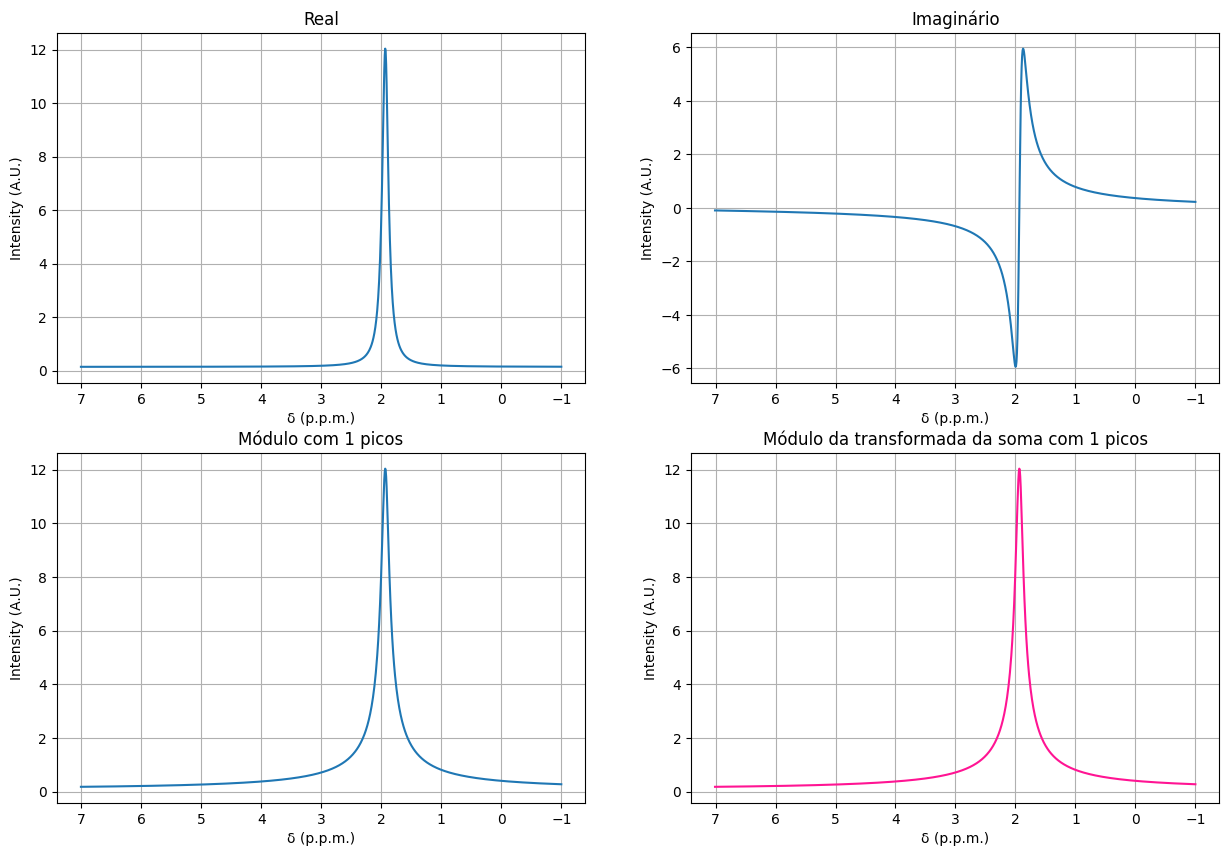

In [46]:
_n_comp = s0__[i][0].size
individual_sigs = np.zeros((_n_comp, c_sigs[0].size), dtype = np.complex128)

for j in range(_n_comp):
    pop = pymri.population(np.array([omega__[i][0][j]]), np.array([t2s__[i][0][j]]), np.array([s0__[i][0][j]]), np.array([phi__[i][0][j]]))
    individual_sigs[j] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]

final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

plt.figure(figsize=(15, 10))
plt.subplot(221)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="real", title= "Real", label=f"{_n_comp - j} maior")

plt.subplot(222)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="imag", title="Imaginário", label=f"{_n_comp - j} maior")

plt.subplot(223)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="abs", title=f"Módulo com {_n_comp} picos", label=f"{_n_comp - j} maior")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = f"Módulo da transformada da soma com {_n_comp} picos", label = "")

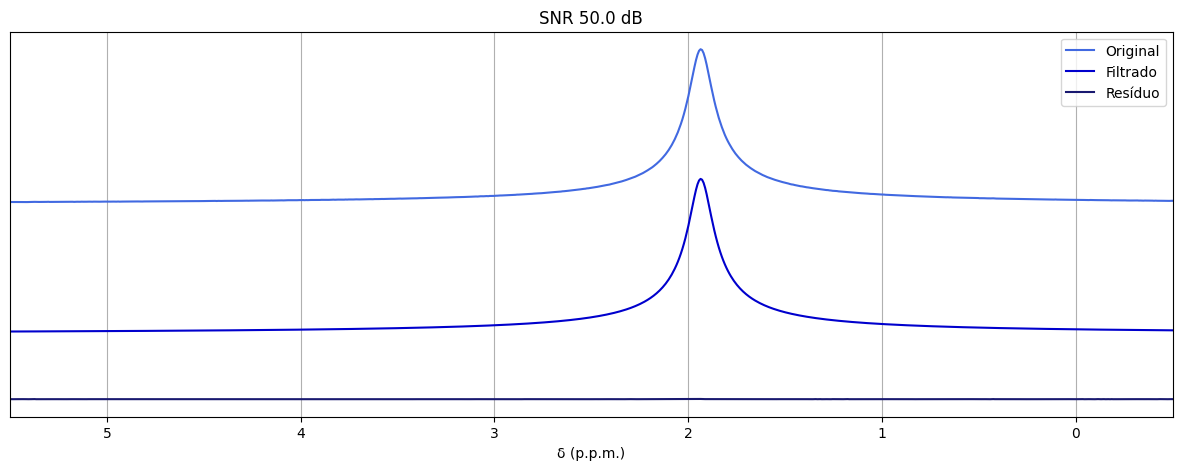

In [47]:
yoffset = 5.0
i = 8

plt.figure(figsize=(15, 5))

plt.plot(freqs, np.absolute(c_sigs[i, :]) + 3*yoffset, c = "royalblue", label = "Original")
plt.plot(freqs, np.absolute(r_sigs[i, :]) + yoffset, c = "mediumblue", label = "Filtrado")
plt.plot(freqs,  np.absolute(residues[i, :]), c = "midnightblue", label = "Resíduo")
plt.xlim(-0.5, 5.5)
plt.title(f"SNR {snrs[i]} dB")
plt.xlabel("δ (p.p.m.)")
# plt.ylabel("Intensidade (U.A.)")
plt.xlim(-0.5, 5.5)
plt.yticks([])
plt.legend()
plt.gca().invert_xaxis() #inverts the x axis
plt.grid()

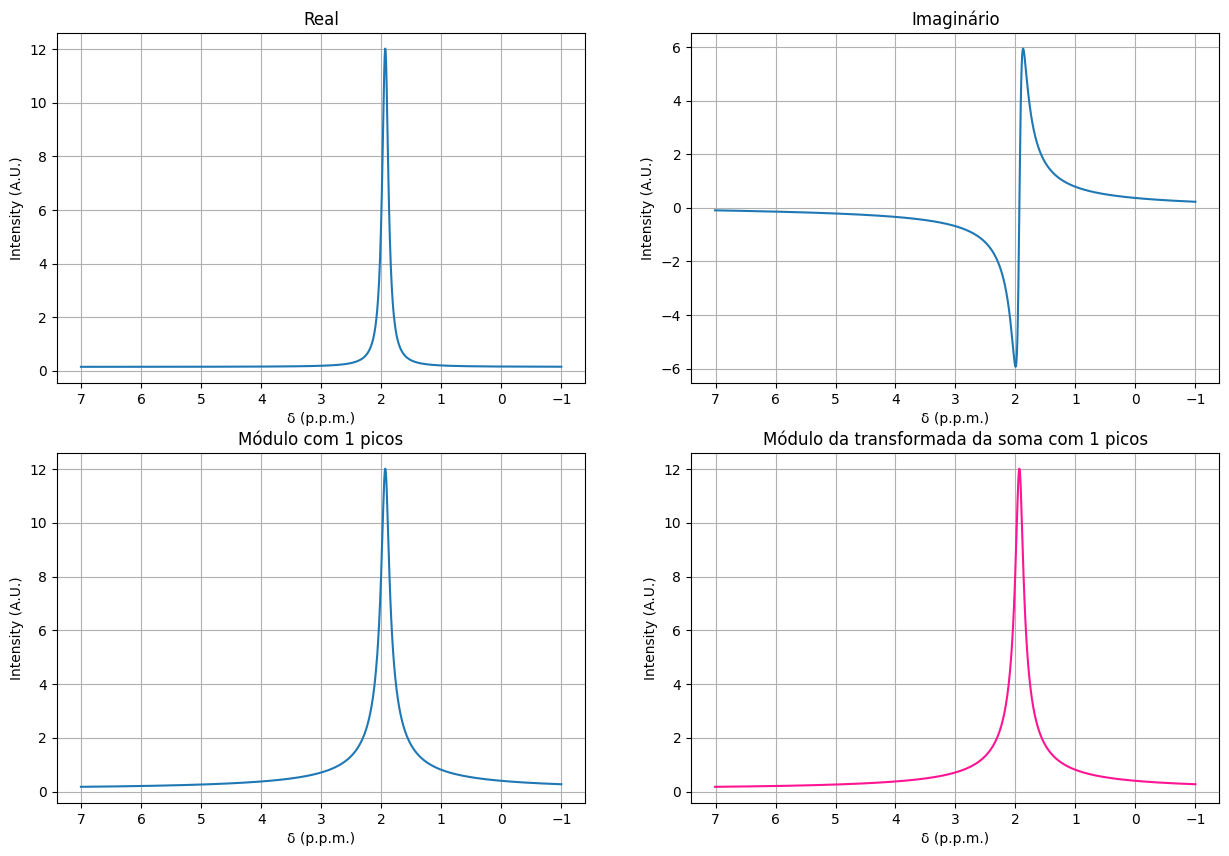

In [48]:
_n_comp = s0__[i][0].size
individual_sigs = np.zeros((_n_comp, c_sigs[0].size), dtype = np.complex128)

for j in range(_n_comp):
    pop = pymri.population(np.array([omega__[i][0][j]]), np.array([t2s__[i][0][j]]), np.array([s0__[i][0][j]]), np.array([phi__[i][0][j]]))
    individual_sigs[j] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]

final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

plt.figure(figsize=(15, 10))
plt.subplot(221)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="real", title= "Real", label=f"{_n_comp - j} maior")

plt.subplot(222)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="imag", title="Imaginário", label=f"{_n_comp - j} maior")

plt.subplot(223)
for j in range(_n_comp): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="abs", title=f"Módulo com {_n_comp} picos", label=f"{_n_comp - j} maior")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = f"Módulo da transformada da soma com {_n_comp} picos", label = "")

In [49]:
def find_interval(arr : np.ndarray, value : float, radius : float, return_indexes : bool = True):
    """Finds the interval, defined by `[value - radius : value + radius]`, of a given ordenated array.
    
    Parameters
    ----------
    
    arr : np.ndarray
        The ordenated array to have the interval found.
    value : float
        The center value of the interval.
    radius : float
        The radius that defines the boundaries of the interval.
    return_indexes : bool = `True`
        Whether to return or not the indexes of the lower and upper boundaries in the array. Default is `True`"""
    assert arr[0] <= value < arr[-1], "Value must be inside the signal's interval."
    assert arr[0] <= value + radius < arr[-1], "Value + radius must be inside the signal's interval."
    assert arr[0] <= value - radius < arr[-1], "Value - radius must be inside the signal's interval."

    diff = np.abs(arr - (value - radius))
    i = np.argmin(diff)

    diff = np.abs(arr - (value + radius))
    j = np.argmin(diff)

    print(arr[i], arr[j])

    if return_indexes == False:
        return arr[i : j]
    else:
        return arr[i : j], i, j

0.9337296690490676 2.937919123610045


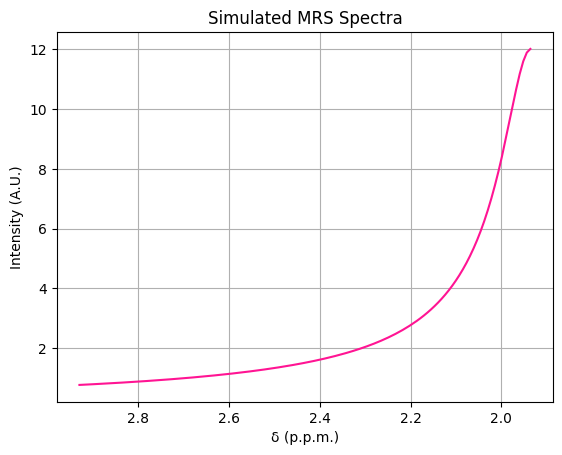

In [50]:
freqs_filtered, x, y = find_interval(freqs, pymri.chem_shift_from_f(pymri.rad_to_hz(ws[0]), B0), 1.0)

pymri.plot_chem_shifts(freqs_filtered, sig_fft[x : y], 1.0)